#### Tweets Uniqueness

In [1]:
import sys
print(sys.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


In [2]:
spark.version

'3.1.3'

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [4]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import col

In [5]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
%%time
twitter = spark.read.parquet('gs://chen26-bdp/original_data')

CPU times: user 9.06 ms, sys: 2.49 ms, total: 11.5 ms
Wall time: 8.36 s


23/03/10 02:42:39 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
keywords = ['college', 'high', 'university', 'students'
            , 'public', 'private', 'secondary', 'primary', 'education', 'undergraduate','graduate']
#filter out rows that do not contain words in keywords
twitter = twitter.withColumn('lower', lower(col('text')))
filter_twitter = twitter.filter(col('lower').rlike('|'.join(keywords)))

twitter_eng = filter_twitter.filter(col('lang') == 'en')
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
tweets = twitter_eng.filter(filter_udf(eng_ord('text')) == True)

#### Description

In [8]:
!pip uninstall -y nltk
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 232.0 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4


In [8]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
%%time
influencer = spark.read.parquet('gs://chen26-bdp/infl')

CPU times: user 3.1 ms, sys: 466 µs, total: 3.57 ms
Wall time: 386 ms


In [13]:
u_df = influencer.filter(col('user_descrip').isNotNull())

In [15]:
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType, BooleanType

eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
user_filt = u_df.filter(filter_udf(eng_ord('user_descrip')) == True)

In [17]:
descr = user_filt.select('user_descrip')

d = descr.rdd.map(lambda x : x['user_descrip']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = d\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    #.zipWithIndex()

In [18]:
tokens.take(5)

[['army', 'armed', 'stand'],
 ['political',
  'science',
  'papers',
  'editor',
  'jjps',
  'board',
  'member',
  'ajcp'],
 ['political', 'analyst'],
 ['like',
  'scotland',
  'hibs',
  'andy',
  'murray',
  'tennis',
  'biden',
  'come',
  'ukraine',
  'could',
  'possibly'],
 ['plug', 'ward', 'theatre', 'data', 'bundles', 'partnerships']]

In [20]:
descrCounts = tokens.flatMap(lambda x: x) \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x, y: x+y) \
    .map(lambda x:(x[1],x[0]))
dCountsSorted = descrCounts.sortByKey(ascending=False)

In [27]:
d = dCountsSorted.map(lambda x : (x[0], x[1]))\
    .toDF(("count", "word"))
d.show(100)

+-----+-------------+
|count|         word|
+-----+-------------+
|45442|       school|
|36959|     official|
|32227|         high|
|32210|      twitter|
|28198|      account|
|23505|   university|
|22357|         love|
|19084|       sports|
|18511|      college|
|17831|         news|
|17030|        state|
|15803|    education|
|15395|        proud|
|15057|      student|
|14883|       follow|
|13930|       social|
|13691|     football|
|13475|        coach|
|13369|         life|
|13212|       former|
|13135|        views|
|12651|       public|
|12498|       tweets|
|11872|    community|
|11833|         like|
|11411|       people|
|10676|     director|
|10599|         team|
|10546|       health|
|10506|     research|
|10345|        media|
|10333|        world|
| 9921|         head|
| 9702|         make|
| 9594|        class|
| 9475|      teacher|
| 9359|   basketball|
| 9291|     students|
| 9284|     business|
| 9198|     opinions|
| 9114|       writer|
| 8896|     national|
| 8661|   

In [9]:
# categorize (roughly)
sport = ['baseball','basketball','tennis','team','coach','football','player','professional','espn','sports',
         'season','nba','nfl','nhl','mlb']
news = ['abc','nbc','fox','cnn','bbc','news','media','reporter','editor']
gov = ['president','potus','biden','senator','congress','vp','flotus','chairman','minister']
celeb = ['musician','author','writer','actor','director','youtuber','instagram','entrepreneur','actress','songwriter','artist']
edu = ['university','school','professor','college','education','history','learning']

In [45]:
influencer = influencer.withColumn('group', \
                      F.when((col('user_descrip').rlike('|'.join(sport))) | (col('user_name').rlike('|'.join(sport))), 'Sports')\
                      .when((col('user_descrip').rlike('|'.join(news))) | (col('user_name').rlike('|'.join(news))), 'News')\
                      .when((col('user_descrip').rlike('|'.join(gov))) | (col('user_name').rlike('|'.join(gov))), 'Gov')\
                      .when((col('user_descrip').rlike('|'.join(edu))) | (col('user_name').rlike('|'.join(edu))), 'Edu')\
                      .when((col('Max_reach') >= 100000)|(col('user_descrip').rlike('|'.join(celeb))) | (col('user_name').rlike('|'.join(celeb))), 'Celebrity') 
                      .otherwise('Other'))

In [46]:
influencer

count,user_id,user_name,Max_reach,user_descrip,total_rct,group
4,484980949,000Dillon000,3504,"Independent, Chri...",3,Other
2,1533841444225839104,000Shub000,1,null,1,Other
1,129785606,000fukumoto,3078,Political science...,8,Other
1,348591369,001Sardar,680,null,1,Other
1,4636687154,0027Woo,58513,⚠️PROBLEMATIC CON...,15,Other
132,2583636176,003rohitsunami,211,null,458,Other
1,1399826340099112964,007Plangzak,77,"Journalist, photo...",4,Celebrity
3,43588936,007__NIL,12616,I Like Scotland &...,2,Sports
2,1317159854977462274,007enterprises,78,Your plug for War...,1,Other
2,1286450080485126146,007girl12,457,Child of God. Wal...,2,Other


In [47]:
influencer.select('group').groupby('group').count()

group,count
Sports,58878
Other,773736
Edu,49720
Gov,2534
Celebrity,38575
News,35523


In [ ]:
# focus on gov, edu, news

In [48]:
influencer.filter(col('group') == 'Edu').orderBy('Max_reach', ascending = False)

count,user_id,user_name,Max_reach,user_descrip,total_rct,group
1,369583954,TheNotoriousMMA,9753739,Two division UFC ...,70,Edu
2,17057271,metmuseum,4316369,"Explore 5,000 yea...",79,Edu
1,1349154719386775552,FLOTUS,3945634,First Lady of the...,26422,Edu
5,204151028,DepEd_PH,3738792,The executive age...,56,Edu
3,14592723,MayoClinic,2060614,An integrated cli...,29,Edu
1,171165627,NBAHistory,1769014,The history of th...,411,Edu
19,18247062,JudicialWatch,1759738,A conservative no...,5155,Edu
17,148529707,RBReich,1585497,Berkeley professo...,175297,Edu
17,39585367,Harvard,1550580,Devoted to excell...,4484,Edu
6,1180533698,fasc1nate,1536303,Posting interesti...,27384,Edu


In [ ]:
# tweets rough categorize

In [10]:
t_group = tweets.select('user','created_at','extended_tweet','retweeted_status','text','id','retweeted_from')
t_group = t_group.withColumn("user_id", col("user").getItem("id")).\
            withColumn('user_name', col('user').getItem('screen_name')).\
            withColumn('user_descrip',col('user').getItem('description')).\
            withColumn('user_followerct',col('user').getItem('followers_count')).\
            withColumn('verify_status', col('user').getItem('verified')).\
            select('user_id', 'user_name', 'user_descrip','user_followerct','verify_status',
            'created_at','text','extended_tweet','retweeted_status','id','retweeted_from')
t_group = t_group.withColumn('retweet_ct', col('retweeted_status').getItem('retweet_count')).\
            withColumn('retweet', col('retweeted_status').getItem('retweeted')).drop('retweeted_status')

In [11]:
t_group = t_group.withColumn('group', \
                F.when(col('verify_status') == 'false', 'Other')
                 .when((col('user_descrip').rlike('|'.join(sport))) | (col('user_name').rlike('|'.join(sport))), 'Sports')\
                 .when((col('user_descrip').rlike('|'.join(news))) | (col('user_name').rlike('|'.join(news))), 'News')\
                 .when((col('user_descrip').rlike('|'.join(gov))) | (col('user_name').rlike('|'.join(gov))), 'Gov')\
                 .when((col('user_descrip').rlike('|'.join(edu))) | (col('user_name').rlike('|'.join(edu))), 'Edu')\
                 .when((col('user_followerct') >= 100000)|(col('user_descrip').rlike('|'.join(celeb))) | (col('user_name').rlike('|'.join(celeb))), 'Celebrity') 
                 .otherwise('Other'))

In [12]:
edu_text = t_group.filter(col('group') == 'Edu').select('id','user_id','user_name','user_descrip', 'text','group','retweet')

In [60]:
edu_text

id,user_id,user_name,user_descrip,text,group,retweet
1604280409147248640,15537451,SLAMonline,RESPECT THE GAME....,RT @SLAMonline: I...,Edu,false
1610637827183632384,2284718570,UjuAnya,Professor. Field:...,RT @NaijaFlyingDr...,Edu,false
1610637968665968641,104985029,SchoolChoiceNow,American Federati...,America’s educati...,Edu,null
1610638319091650560,80128797,VizcayaMuseum,Preserving the es...,RT @Everglades_La...,Edu,false
1520045643179249665,396752631,ashleynmcb,covering Oakland ...,Catie Tombs is a ...,Edu,null
1550120060781350912,780206406024691712,neal_katyal,Supreme Court law...,So excited that @...,Edu,null
1550120229769842689,109608297,MaudMaron,https://lnk.bio/m...,Healthy athletes ...,Edu,null
1547724056526331912,14416109,alexanderrusso,Founder of @thegr...,RT @akilbello: PS...,Edu,false
1557721016713023489,276989862,wrightstate,Named for Ohio's ...,Safety first! The...,Edu,null
1557721048111529984,17724276,ucu,University and Co...,We have hundreds ...,Edu,null


In [16]:
#edu original posts
ori_text = edu_text.filter(col('retweet').isNull())

In [62]:
ori_text.count()

24919

In [17]:
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType

df_text = ori_text.select('text')
eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
text_filter = df_text.filter(filter_udf(eng_ord('text')) == True)

In [21]:
text = text_filter.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [22]:
row = Row('text')
text_data=text.map(row).zipWithIndex().toDF(['text','id'])
text_data.show(5)

+--------------------+---+
|                text| id|
+--------------------+---+
|{America’s educat...|  0|
|{Catie Tombs is a...|  1|
|{So excited that ...|  2|
|{Healthy athletes...|  3|
|{Safety first! Th...|  4|
+--------------------+---+
only showing top 5 rows



In [23]:
df_tokens = spark.createDataFrame(tokens, ["text_words",'id'])
df_tokens = df_tokens.filter(size('text_words') >= 1)

In [67]:
df_tokens

text_words,id
"[education, syste...",0
"[catie, tombs, te...",1
"[excited, next, g...",2
"[healthy, athlete...",3
"[safety, wright, ...",4
"[hundreds, thousa...",5
"[join, south, hig...",6
"[berea, college, ...",7
"[deputy, universi...",8
"[great, radio, lo...",9


In [16]:
import re
import nltk
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
!pip install simhash

In [21]:
from simhash import Simhash, SimhashIndex

In [27]:
vectorize = CountVectorizer(inputCol="text_words", outputCol="features", minDF=1.0)
text_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [72]:
text_vectorize.limit(5).toPandas()

,text_words,id,features
0,"[education, system, parents, using, school, choice, voices]",0,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[catie, tombs, teacher, metwest, high, expulsions, metwest, year, worried]",1,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[excited, next, going, take, college]",2,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[healthy, athletes, college, kids, young, people, different, decision, regarding]",3,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[safety, wright, state, university, police, department, provides, campus, police, services]",4,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [73]:
text_vectorize.select('features').limit(5).show(5)

+--------------------+
|            features|
+--------------------+
|(17595,[288,702,1...|
|(17595,[0,4,5,36,...|
|(17595,[119,124,1...|
|(17595,[3,42,101,...|
|(17595,[1,2,4,42,...|
+--------------------+



In [10]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_text = mh.fit(text_vectorize)
text_hashed = mh.fit(text_vectorize).transform(text_vectorize)

In [75]:
text_hashed.show(5)

+--------------------+---+--------------------+--------------------+
|          text_words| id|            features|              hashes|
+--------------------+---+--------------------+--------------------+
|[education, syste...|  0|(17595,[0,5,90,18...|[[4.7945584E7], [...|
|[catie, tombs, te...|  1|(17595,[4,15,64,3...|[[2.56879666E8], ...|
|[excited, next, g...|  2|(17595,[2,55,58,1...|[[1.1707592E8], [...|
|[healthy, athlete...|  3|(17595,[2,85,146,...|[[2.99236534E8], ...|
|[safety, wright, ...|  4|(17595,[3,9,23,16...|[[6.56996916E8], ...|
+--------------------+---+--------------------+--------------------+
only showing top 5 rows



In [76]:
df_hashed_text = text_data.join(text_hashed, "id", how = 'left')

In [ ]:
%%time
df_hashed_text.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/text_hash')

In [8]:
%%time
text_vectorize.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/text_vectorize')

NameError: name 'text_vectorize' is not defined

In [9]:
df_hashed_text = spark.read.parquet('gs://chen26-bdp/text_hash')
text_vectorize = spark.read.parquet('gs://chen26-bdp/text_vectorize')

In [80]:
df_hashed_text

id,text,text_words,features,hashes
418,{A college intern...,"[college, letter,...","(17595,[2,80,138,...","[[5.75251383E8], ..."
415,{@clam_57 @FrankL...,"[bailouts, corpor...","(17595,[11,298,34...","[[5.201327E7], [5..."
414,"{Or this guy, who...","[looks, like, hig...","(17595,[0,4,31,64...","[[4.7945584E7], [..."
427,"{Dash '22, commit...","[dash, committed,...","(17595,[5,43,550,...","[[1.75609176E8], ..."
406,{OMG. Reminds me ...,"[reminds, another...","(17595,[0,4,201,2...","[[4.7945584E7], [..."
421,{Gifted education...,"[gifted, educatio...","(17595,[5,242,253...","[[1.42306314E8], ..."
412,{#UVM’s Class of ...,"[class, 2026, uni...","(17595,[3,25,448,...","[[8.30079935E8], ..."
417,{Kicking off a co...,"[kicking, communi...","(17595,[6,7,10,22...","[[2.30106198E8], ..."
420,{Do you want to m...,"[want, make, mark...","(17595,[2,38,63,4...","[[2.26069964E8], ..."
402,{The University o...,"[university, tole...","(17595,[3,54,87,1...","[[1.8678956E7], [..."


In [19]:
jaccard_distance = 0.5

df_dups_text_50 = model_text.approxSimilarityJoin(text_hashed, text_hashed, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"),
            col('datasetA.text_words').alias('text_A'),
            col('datasetB.text_words').alias('text_B'))

In [28]:
text_hashed.count()

24880

In [31]:
df_dups_text_50.limit(5).show()

+-------+-----+-----+--------------------+--------------------+
|distCol| id_A| id_B|              text_A|              text_B|
+-------+-----+-----+--------------------+--------------------+
|    0.0|14591|19340|[strongest, argum...|[strongest, argum...|
|    0.0| 6249|19928| [college, football]| [college, football]|
|    0.0| 4080| 5520|[opponents, schoo...|[opponents, schoo...|
|    0.0| 3158| 7905|[recent, study, l...|[recent, study, l...|
|    0.0|12767|19803|[homeless, makes,...|[homeless, makes,...|
+-------+-----+-----+--------------------+--------------------+



In [22]:
df_dups_text_50 = df_dups_text_50.toPandas()

In [27]:
df_dups_text_50

,distCol,id_A,id_B,text_A,text_B
0,0.000000,3911,6356,"[starting, kansas, city, public, schools, board, directors, needs, join, online, today]","[starting, kansas, city, public, schools, board, directors, needs, join, online, today]"
1,0.000000,5933,11993,"[operating, hawaiian, schools, engaging, communities, transform, educational]","[operating, hawaiian, schools, engaging, communities, transform, educational]"
2,0.000000,14636,17149,"[care, solace, connects, school, staff, families, cost, quickly]","[care, solace, connects, school, staff, families, cost, quickly]"
3,0.357143,3911,14373,"[starting, kansas, city, public, schools, board, directors, needs, join, online, today]","[kansas, city, public, schools, board, directors, needs, join, person, online, give, feedback]"
4,0.000000,5933,6477,"[operating, hawaiian, schools, engaging, communities, transform, educational]","[operating, hawaiian, schools, engaging, communities, transform, educational]"
...,...,...,...,...,...
6567,0.000000,3865,23105,"[federation, partnerships, university, london, senate, house]","[federation, partnerships, university, london, senate, house]"
6568,0.444444,4624,19065,"[wake, tech, graduates, earn, average, year, high, school]","[high, school, graduates, average, earn, annual, average, annual]"
6569,0.000000,5482,6869,"[high, school]","[high, school]"
6570,0.000000,1884,24269,"[used, college, education, solid, defense, poverty, writer, loki, argues]","[used, college, education, solid, defense, poverty, writer, loki, argues]"


In [15]:
sample = text_hashed.limit(10000)

In [16]:
jaccard_distance = 0.5

df_dups_text_05 = model_text.approxSimilarityJoin(sample, sample, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"))
            #col('datasetA.text_words').alias('text_A'),
            #col('datasetB.text_words').alias('text_B'))

In [17]:
records = sample.count()
dups_50_text_distinct = df_dups_text_05.select('id_A').distinct()
dups_50_text = dups_50_text_distinct.count()
uniques = records - dups_50_text

print ('Total records: ', records)
print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups_50_text)
print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  10000
Duplicate titles based on { 0.5 } jaccard distance:  598
Unique titles based on { 0.5 } jaccard distance:  0.5 :  9402


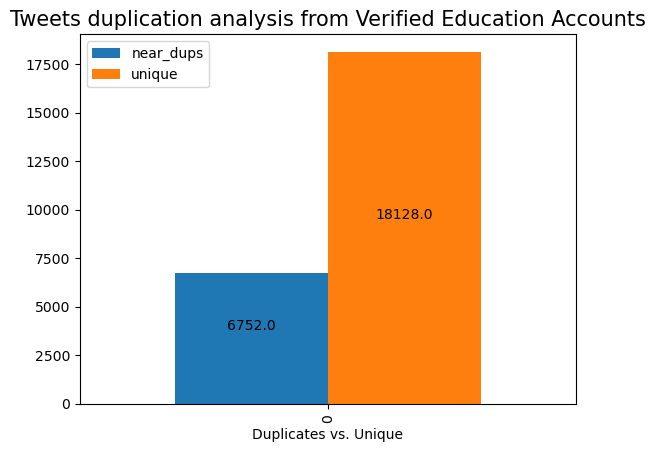

In [32]:
dups_df = pd.DataFrame.from_dict({'near_dups': [6752], 'unique': [18128]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis from Verified Education Accounts', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# verified group gov account

In [41]:
gov_text = t_group.filter(col('group') == 'Gov').select('id','user_id','user_name','user_descrip', 'text','group','retweet')
ori_gov = gov_text.filter(col('retweet').isNull())

In [42]:
ori_gov.count()

1036

In [46]:
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType

df_text = ori_gov.select('text')
eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
text_filter = df_text.filter(filter_udf(eng_ord('text')) == True)

In [47]:
text = text_filter.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('text')
text_data=text.map(row).zipWithIndex().toDF(['text','id'])
text_data.show(5)

+--------------------+---+
|                text| id|
+--------------------+---+
|{@profmarkcollard...|  0|
|{Great day at ⁦@T...|  1|
|{Another ~$400 bi...|  2|
|{UO President Mic...|  3|
|{Per University o...|  4|
+--------------------+---+
only showing top 5 rows



In [48]:
df_tokens_gov = spark.createDataFrame(tokens, ["text_words",'id'])
df_tokens_gov = df_tokens_gov.filter(size('text_words') >= 1)

In [49]:
vectorize = CountVectorizer(inputCol="text_words", outputCol="features", minDF=1.0)
text_vectorize_gov = vectorize.fit(df_tokens_gov).transform(df_tokens_gov)

In [50]:
%%time
text_vectorize_gov.write.format("parquet").\
mode('overwrite').\
save('gs://chen26-bdp/text_vectorize_gov')

CPU times: user 1.06 s, sys: 254 ms, total: 1.31 s
Wall time: 6min 58s


In [10]:
text_vectorize_gov = spark.read.parquet('gs://chen26-bdp/text_vectorize_gov')

In [11]:
text_vectorize_gov 

text_words,id,features
"[norwalk, public,...",57,"(3078,[5,6,375],[..."
"[gets, decide, je...",58,"(3078,[2,13,206,2..."
"[henry, army, vet...",59,"(3078,[1,5,30,122..."
"[henry, army, vet...",60,"(3078,[1,5,30,122..."
"[henry, army, vet...",61,"(3078,[1,5,30,122..."
"[signed, srinivas...",62,"(3078,[2,4,128,58..."
"[says, cyber, cha...",962,"(3078,[5,6,27,38,..."
"[notes, current, ...",963,"(3078,[1,5,36,132..."
"[invest, invest, ...",964,"(3078,[1,5,61,328..."
"[national, lung, ...",965,"(3078,[0,22,232,3..."


In [13]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_text_gov = mh.fit(text_vectorize_gov)
text_hashed_gov = mh.fit(text_vectorize_gov).transform(text_vectorize_gov)

In [16]:
jaccard_distance = 0.5

df_dups_text_gov_50 = model_text_gov.approxSimilarityJoin(text_hashed_gov, text_hashed_gov, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"),
            col('datasetA.text_words').alias('text_A'),
            col('datasetB.text_words').alias('text_B'))

In [19]:
df_dups_text_gov_50_df = df_dups_text_gov_50.toPandas()

In [20]:
df_dups_text_gov_50_df

,distCol,id_A,id_B,text_A,text_B
0,0.000000,805,939,"[school, high, quality, like, international, order]","[school, high, quality, like, international, order]"
1,0.000000,59,61,"[henry, army, veteran, school, teacher, running, congress, northern, believed, public]","[henry, army, veteran, school, teacher, running, congress, northern, believed, public]"
2,0.000000,492,677,"[abvp, delegation, leadership, national, general, secretary, chairman, university]","[abvp, delegation, leadership, national, general, secretary, chairman, university]"
3,0.333333,161,943,"[college, football, best]","[college, football]"
4,0.333333,201,943,"[watch, college, football]","[college, football]"
5,0.200000,843,914,"[programme, organised, college, director, general]","[programme, organised, college, director]"
6,0.333333,540,943,"[college, football, dying]","[college, football]"
7,0.250000,161,566,"[college, football, best]","[college, football, fans, best]"
8,0.333333,322,943,"[months, college, football]","[college, football]"
9,0.400000,417,1001,"[time, bring, back, college, football]","[college, football, back]"


In [21]:
text_hashed_gov.count()

1035

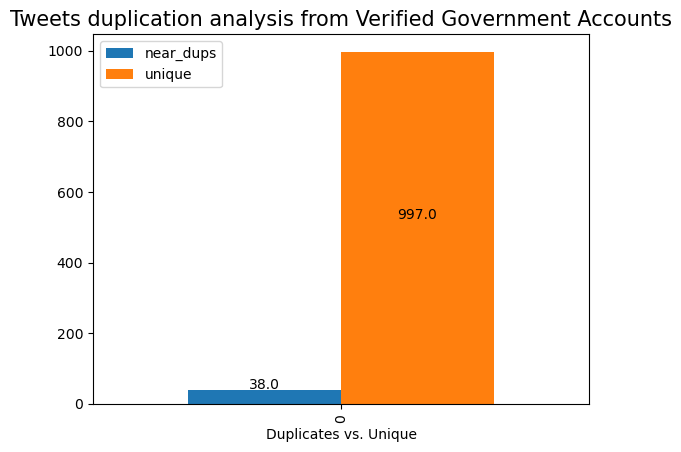

In [23]:
dups_df = pd.DataFrame.from_dict({'near_dups': [38], 'unique': [997]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis from Verified Government Accounts', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# all original text without grouping

In [28]:
original = t_group.filter(col('retweet').isNull())
original = original.select('user_id','user_name','verify_status','text','id','retweeted_from','retweet')
original = original.drop('retweet')

In [29]:
original

user_id,user_name,verify_status,text,id,retweeted_from
1101871913771692032,SualihTemam,false,#世界杯 #幸运飞艇https...,1604278587183415297,null
791367120617607168,bluddystyles,false,the fact that I g...,1604278598155702273,null
2613254236,Rosaline536,false,Selling my 4x The...,1604278614748528642,null
1413848524517687296,kpopmisandrist,false,If you're confusi...,1604278620993757186,null
1437582409906655236,WillieETCarver,false,@bungalow3500 Tha...,1604278643693424643,null
1449084294828371974,Lann_Andrews,false,Homework | nursin...,1604278651373199361,null
1350274870827954180,prairiestatebn,false,Wasn’t wild about...,1604278654892183553,null
1597799368262037504,ZaxNewsStand,false,Former Alabama Re...,1604278661267574785,null
1422734857776533504,kevin_kershner,false,@YaOnlyLivvOnce I...,1604278675108597760,null
1230812852535070720,slmjim44,false,@Choomb4TF @SaSSa...,1604278675477860352,SaSSaBJJ @s1mpleO...


In [30]:
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType

df_text = original.select('id', 'text')
eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
text_filter = df_text.filter(filter_udf(eng_ord('text')) == True)

In [31]:
d = text_filter.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
# remove stop words
tokens = d\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.sub("@[A-Za-z0-9_]+","", document))\
        .map( lambda document: re.sub(r'[^\w\s]', '', document))\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if x.isalnum()])\
        .map( lambda word: [x for x in word if len(x) > 3] )\
        .map( lambda word: [x for x in word if x not in StopWords])

In [32]:
t = tokens.zip(text_filter.select('id').rdd.flatMap(lambda x:x))
df_tokens = t.toDF(['tokens', 'id'])
eng = df_tokens.filter(size("tokens")>=1)

In [64]:
eng

tokens,id
"[college, husband...",1604278587183415297
"[fact, asked, tra...",1604278598155702273
"[selling, 1975, t...",1604278614748528642
"[youre, confusing...",1604278620993757186
"[leftmost, sign, ...",1604278643693424643
"[homework, nursin...",1604278651373199361
"[wasnt, wild, fru...",1604278654892183553
"[former, alabama,...",1604278661267574785
"[love, chicago, l...",1604278675108597760
"[fake, occupation...",1604278675477860352


In [33]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

def filter_non_english(df, col_name):
    non_english_pattern = re.compile(r'[^\x00-\x7F]+')
    def contains_non_english_words(words):
        for word in words:
            if non_english_pattern.search(word):
                return True
        return False
    
    contains_non_english_udf = udf(contains_non_english_words, BooleanType())
    filtered_df = df.filter(~contains_non_english_udf(df[col_name]))
    
    return filtered_df

eng = filter_non_english(eng, 'tokens')


In [19]:
eng

tokens,id
"[college, husband...",1604278587183415297
"[youre, confusing...",1604278620993757186
"[former, alabama,...",1604278661267574785
"[players, drafted...",1604278701407219712
"[sprinter, high, ...",1604278736148275200
"[pajama, pants, f...",1604278740065869824
"[look, body, spra...",1604278741248663552
"[last, adult, fam...",1604278768272838659
"[high, school, pe...",1604278778682810373
[reveal],1604278793195003904


In [ ]:
eng.count()

13420117

In [34]:
sample_text = eng.limit(10000)

In [35]:
vectorize = CountVectorizer(inputCol="tokens", outputCol="features", minDF=1.0)
text_vectorize = vectorize.fit(sample_text).transform(sample_text)
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
text_model = mh.fit(text_vectorize)
text_hashed = mh.fit(text_vectorize).transform(text_vectorize)

In [26]:
text_vectorize

tokens,id,features
"[yall, remember, ...",1569395003973066752,"(15641,[0,108,139..."
"[made, friends, c...",1569395007379116032,"(15641,[0,1,2,68,..."
"[wingstop, jamba,...",1569395015268564992,"(15641,[1,2,49,62..."
"[high, school, so...",1569395020259819520,"(15641,[1,2,26,32..."
"[greatness, evalu...",1569395022340005892,"(15641,[3,14,16,1..."
"[well, going, col...",1569395032972750848,"(15641,[0,33,60,8..."
"[college, time, g...",1569395045274460160,"(15641,[0,20,57,1..."
"[college, really,...",1569395051427422217,"(15641,[0,54,457,..."
"[accepted, commun...",1569395065436655616,"(15641,[0,102,111..."
"[west, point, hig...",1569395070448840706,"(15641,[1,2,92,19..."


In [ ]:
text_hashed

tokens,id,features,hashes
"[college, husband...",1604278587183415297,"(15539,[0,104,782...","[[4.7945584E7], [..."
"[youre, confusing...",1604278620993757186,"(15539,[3,75,89,1...","[[7.5194095E7], [..."
"[former, alabama,...",1604278661267574785,"(15539,[0,8,249,4...","[[2.0704936E7], [..."
"[players, drafted...",1604278701407219712,"(15539,[6,20,25,2...","[[5.8542664E7], [..."
"[sprinter, high, ...",1604278736148275200,"(15539,[1,2,149,2...","[[5.75251383E8], ..."
"[pajama, pants, f...",1604278740065869824,"(15539,[0,4,634,1...","[[4.7945584E7], [..."
"[look, body, spra...",1604278741248663552,"(15539,[0,79,139,...","[[4.7945584E7], [..."
"[last, adult, fam...",1604278768272838659,"(15539,[55,201,63...","[[8.1754941E7], [..."
"[high, school, pe...",1604278778682810373,"(15539,[1,2,67,80...","[[2.13454767E8], ..."
[reveal],1604278793195003904,"(15539,[14210],[1...","[[5.74269845E8], ..."


In [ ]:
jaccard_distance = 0.5
df_dups_text = text_model.approxSimilarityJoin(text_hashed, text_hashed, jaccard_distance).\
    filter("datasetA.id < datasetB.id").select(col("distCol"),\
    col("datasetA.id").alias("id_A"),
    col("datasetB.id").alias("id_B"))

df_dups_text.show()

23/03/09 20:07:01 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 32.0 (TID 7963) (hub-msca-chen26-bdp-chen26-w-0.c.chen26-bdp-class-project.internal executor 21): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3752/181969739: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage5.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$ConcatIterator.hasNext(Iterator.scala:224)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.ca

+-------------------+-------------------+-------------------+
|            distCol|               id_A|               id_B|
+-------------------+-------------------+-------------------+
|                0.4|1517190870121996288|1622547699458351104|
|0.16666666666666663|1517190897548550144|1517191706734649347|
|0.16666666666666663|1517190897548550144|1517191145939517441|
|0.33333333333333337|1517190954113015813|1549424569630576641|
|0.33333333333333337|1517190954113015813|1564108139527487488|
|0.33333333333333337|1517190954113015813|1575539471067410432|
|0.33333333333333337|1517190954113015813|1568809101152370689|
|0.33333333333333337|1517190954113015813|1554421877942140929|
|0.33333333333333337|1517190954113015813|1594744950474035200|
|0.33333333333333337|1517190954113015813|1622498125817454592|
|0.16666666666666663|1517191145939517441|1517191706734649347|
|0.19999999999999996|1517191196724051971|1517191330623066112|
|                0.4|1517191317884973059|1566648298819158022|
| 0.1333

In [ ]:
# original news tweets

In [12]:
news_text = t_group.filter(col('group') == 'News').select('id','user_id','user_name','user_descrip', 'text','group','retweet')
ori_news = news_text.filter(col('retweet').isNull())
ori_news = ori_news.sample(False, 10000/len(ori_news.collect()), 1000)

In [13]:
from pyspark.sql import functions as F
from pyspark.sql import types as t
from pyspark.sql.types import ArrayType, IntegerType

df_text_news = ori_news.select('text')
eng_ord=F.udf(lambda x: [ord(a) for a in x],t.ArrayType(IntegerType()))

def english_filter(x):
    for index in range(len(x)):
        if x[index] > 128:
            return False
        else:
            return True

filter_udf = F.udf(english_filter, BooleanType())
news_text_filter = df_text_news.filter(filter_udf(eng_ord('text')) == True)

In [ ]:
news_text = news_text_filter.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = news_text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

row = Row('text')
news_text_data=news_text.map(row).zipWithIndex().toDF(['text','id'])

In [17]:
df_tokens_news = spark.createDataFrame(tokens, ["text_words",'id'])
df_tokens_news = df_tokens_news.filter(size('text_words') >= 1)
vectorize = CountVectorizer(inputCol="text_words", outputCol="features", minDF=1.0)
text_vectorize_news = vectorize.fit(df_tokens_news).transform(df_tokens_news)

In [28]:
from pyspark.ml.linalg import Vector
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

def is_not_empty_vector(vect: Vector) -> bool:
    if_not_empty = vect.numNonzeros > 0
    return if_not_empty
 
is_nonzero_vector_udf = udf(is_not_empty_vector, BooleanType())

text_vectorize_news = text_vectorize_news.withColumn("notEmpty", is_nonzero_vector_udf("features")) 



In [29]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model_text_news = mh.fit(text_vectorize_news)
text_hashed_news = mh.fit(text_vectorize_news).transform(text_vectorize_news)

In [30]:
jaccard_distance = 0.5

df_dups_text_news_50 = model_text_news.approxSimilarityJoin(text_hashed_news, text_hashed_news, jaccard_distance).\
filter("datasetA.id < datasetB.id").select(
            col("distCol"),
             col("datasetA.id").alias("id_A"),
             col("datasetB.id").alias("id_B"))